<a href="https://colab.research.google.com/github/chitranshp/Image-noise-reduction/blob/master/Denoising_images_using_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from tensorflow.keras.utils import to_categorical


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float')/255.0
x_test = x_test.astype('float')/255.0

x_train = np.reshape(x_train, (60000, 784))
x_test = np.reshape(x_test, (10000, 784))


11493376/11490434 [==============================] - 0s 0us/step


In [0]:
x_train_noisy = x_train + np.random.rand(60000, 784) * 0.9
x_test_noisy = x_test + np.random.rand(10000, 784) * 0.9
x_train_noisy = np.clip(x_train_noisy, 0. , 1.)
x_test_noisy = np.clip(x_test_noisy, 0. , 1.)

In [0]:
def plot(x, p, labels = False):
    plt.figure(figsize = (20, 2))
    for i in range(1, 10):
        plt.subplot(1, 10, i+1)
        plt.imshow(x[i].reshape(28,28), cmap = 'binary')
        plt.xticks([])
        plt.yticks([])
        if labels:
          plt.xlabel(np.argmax(p[i]))
    plt.show()

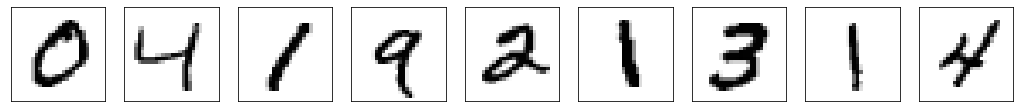

In [5]:
plot(x_train, None)

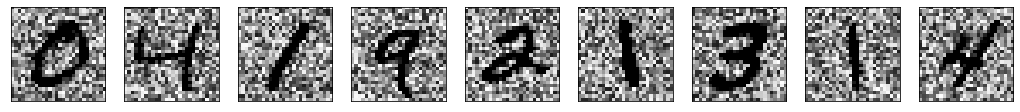

In [6]:
plot(x_train_noisy, None)

In [0]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if (logs.get('accuracy') > 0.97):
            print("\n Achieved more than 97% accuracy, Hence terminating training!!!")
            self.model.stop_training = True
callbacks = myCallback()

In [8]:
classifier = Sequential([
    Dense(256, activation = 'relu', input_shape = (784,)),
    Dense(256, activation = 'relu'),
    Dense(10, activation = 'softmax')
])

classifier.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2570      
Total params: 269,322
Trainable params: 269,322
Non-trainable params: 0
_________________________________________________________________


In [9]:
classifier.fit(x_train, y_train, epochs = 20, callbacks = [callbacks])

Epoch 1/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2033 - accuracy: 0.9386
Epoch 2/20
1875/1875 [==============================] - ETA: 0s - loss: 0.0838 - accuracy: 0.9747
 Achieved more than 97% accuracy, Hence terminating training!!!
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0838 - accuracy: 0.9747


In [10]:
loss, acc = classifier.evaluate(x_train, y_train)
print('Training accuracy:{}\n'.format(acc))
loss, acc = classifier.evaluate(x_test, y_test)
print('Test accuracy:{}'.format(acc))

1875/1875 [==============================] - 3s 1ms/step - loss: 0.0528 - accuracy: 0.9835
Training accuracy:0.9835000038146973

313/313 [==============================] - 1s 2ms/step - loss: 0.0822 - accuracy: 0.9746
Test accuracy:0.9746000170707703


In [11]:
print('Evaluating classifier on noisy images')
loss, acc = classifier.evaluate(x_train_noisy, y_train)
print('\nTraining accuracy:{}'.format(acc))
loss, acc = classifier.evaluate(x_test_noisy, y_test)
print('\nTest accuracy:{}'.format(acc))


Evaluating classifier on noisy images
1875/1875 [==============================] - 3s 1ms/step - loss: 3.0401 - accuracy: 0.2676

Training accuracy:0.26759999990463257
313/313 [==============================] - 0s 2ms/step - loss: 3.0560 - accuracy: 0.2742

Test accuracy:0.2741999924182892


In [0]:
input_image = Input(shape = (784,))
encoded = Dense(64, activation = 'relu')(input_image)
decoded = Dense(784, activation = 'sigmoid')(encoded)

autoencoder = Model(input_image, decoded)
autoencoder.compile(loss = 'binary_crossentropy', optimizer = 'adam')

In [13]:
autoencoder.fit(x_train_noisy, 
                x_train, 
                epochs = 100, 
                batch_size = 256, 
                verbose = False, 
                validation_split = 0.2,
                callbacks = [
                             EarlyStopping(monitor = 'val_loss', patience = 5),
                             LambdaCallback(on_epoch_end = lambda epoch, logs: print('Validation loss: {}'.format(logs['val_loss'])))
                             ]
                )

Validation loss: 0.2242397516965866
Validation loss: 0.18122756481170654
Validation loss: 0.1618424654006958
Validation loss: 0.14887765049934387
Validation loss: 0.1394825577735901
Validation loss: 0.13229553401470184
Validation loss: 0.1267513483762741
Validation loss: 0.12235196679830551
Validation loss: 0.11921891570091248
Validation loss: 0.11656982451677322
Validation loss: 0.11442679166793823
Validation loss: 0.11277514696121216
Validation loss: 0.1115431860089302
Validation loss: 0.11039330065250397
Validation loss: 0.10939967632293701
Validation loss: 0.10881290584802628
Validation loss: 0.10805764049291611
Validation loss: 0.10760647803544998
Validation loss: 0.10716120153665543
Validation loss: 0.10701904445886612
Validation loss: 0.10679370909929276
Validation loss: 0.10641182214021683
Validation loss: 0.10631716251373291
Validation loss: 0.10620897263288498
Validation loss: 0.10611160099506378
Validation loss: 0.10613483935594559
Validation loss: 0.10585099458694458
Valida

In [0]:
pred = autoencoder.predict(x_test_noisy)

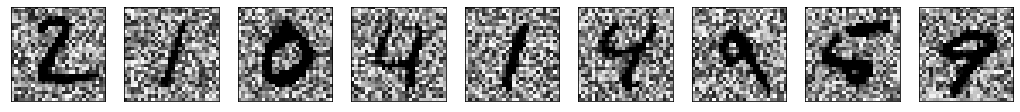

In [15]:
plot(x_test_noisy, None)

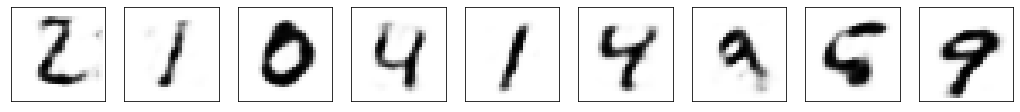

In [16]:
plot(pred, None)

In [17]:
acc = classifier.evaluate(pred, y_test)

313/313 [==============================] - 0s 2ms/step - loss: 0.1554 - accuracy: 0.9515


Combining above two models into a single model named denoise_and_classify 

In [0]:
input_image = Input(shape = (784,))
x = autoencoder(input_image)
y = classifier(x)

denoise_and_classify = Model(input_image, y)

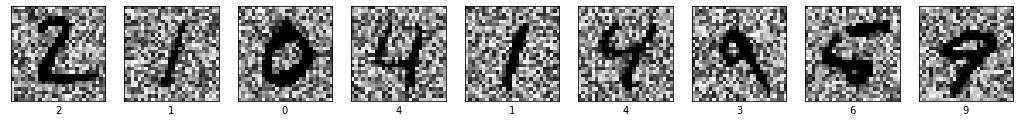

In [21]:
predictions = denoise_and_classify(x_test_noisy)
plot(x_test_noisy, predictions, True)

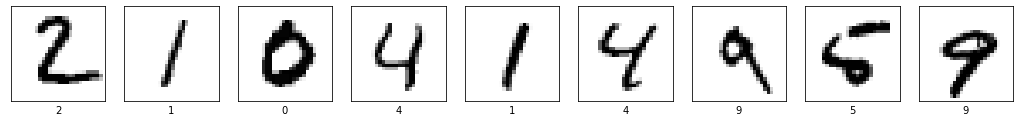

In [25]:
plot(x_test, to_categorical(y_test), True)

We can see that model has classified most of the images correctly. But since we have used a simple autoencoder, there are some misclassifications. To improve it we can one of the following methods:


*   Applying a **sparsity constraint** on the autoencoder
*   **Deeper** autoencoder
*   **Convolutional** autoencoder (Preferred choice) 
*   **Variational** autoencoder (This is a newer ***generative model*** and still research work is being done on it)



